### Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import cv2
import joblib
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import scipy
import scipy.signal
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import xlrd



import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans                    # to import Kmeans Clusterring
from sklearn.model_selection import GridSearchCV      # to import Grid method for training
from sklearn.neighbors import KNeighborsClassifier    # to import KNN
from sklearn.svm import LinearSVC                     # to import SVC with linear kernel
from sklearn.svm import SVC                           # to import SVC
from sklearn.tree import DecisionTreeClassifier       # to import Decision tree classifier
from sklearn.ensemble import RandomForestClassifier   # to import random forest classifier
from sklearn.neighbors import KNeighborsClassifier    
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold    
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Data-Preprocessing and Feature Extraction 

In [2]:
def matrix_from_csv_file(file_path):
    
    csv_data = np.genfromtxt(file_path, delimiter = ',')
    full_matrix = csv_data[2:] 
    return full_matrix

### Window Slicing

In [3]:
def get_slice (full_matrix,  t, frame):
    tot_len = full_matrix[:,0].size
   
    
    restart = full_matrix[0, 0] + t
    index_0 = int(restart)
    index_1 = int(restart + frame)
    #print('index_0', index_0)
    #print('index_1', index_1)
    duration = frame#full_matrix[index_1, 0] - full_matrix[index_0, 0]
    #print('Duration is', duration )
    #print('FULL MATRIX ', full_matrix[index_0:index_1, :])
    return full_matrix [index_0:index_1, :], duration

### Notch Filter


In [4]:
def notch_filter(x, samplerate, plot=False):
    x = x - np.mean(x)

    high_cutoff_notch = 49 / (samplerate / 2)
    low_cutoff_notch = 51 / (samplerate / 2)

    # Band Stop Filter (BSF) or Band Reject Filter
    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt### Window Slicing

### Band-Pass Filter

In [5]:
def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)
    #print(len(x))

    if plot:
        t = np.arange(0, len(x.transpose()) / samplerate, 1 / samplerate)
        plt.plot(t, x.transpose())
        plt.plot(t, x_filt.transpose(), 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


### Mean

In [6]:
def feature_mean(matrix):
  
    ret = np.mean(matrix, axis = 0).flatten()
    #print('MEAN RET VALUE',ret )
    names = ['mean_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_mean_d(h1, h2):

    ret = (feature_mean(h2)[0] - feature_mean(h1)[0]).flatten()


    # Fixed naming [fcampelo]
    names = ['mean_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names



def feature_mean_q(q1, q2, q3, q4):

    v1 = feature_mean(q1)[0]
    v2 = feature_mean(q2)[0]
    v3 = feature_mean(q3)[0]
    v4 = feature_mean(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['mean_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['mean_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names

### Standard Deviation

In [7]:
def feature_stddev(matrix):
 


    # fix ddof for finite sampling correction (N-1 instead of N in denominator)
    ret = np.std(matrix, axis = 0, ddof = 1).flatten()
    names = ['std_' + str(i) for i in range(matrix.shape[1])]

    return ret, names



def feature_stddev_d(h1, h2):
 

    ret = (feature_stddev(h2)[0] - feature_stddev(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['std_d_h2h1_' + str(i) for i in range(h1.shape[1])]

    return ret, names### Band-Pass Filter

In [8]:
def feature_moments(matrix):
 

    skw = scipy.stats.skew(matrix, axis = 0, bias = False)
    krt = scipy.stats.kurtosis(matrix, axis = 0, bias = False)
    ret  = np.append(skw, krt)
    #print('MOMENTS SHAPE' , ret.shape)
    names = ['skew_' + str(i) for i in range(matrix.shape[1])]
    names.extend(['kurt_' + str(i) for i in range(matrix.shape[1])])
    return ret, names

### Max and Min


In [9]:
def feature_max(matrix):
  

    ret = np.max(matrix, axis = 0).flatten()
    names = ['max_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_max_d(h1, h2):
   

    ret = (feature_max(h2)[0] - feature_max(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['max_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names


def feature_max_q(q1, q2, q3, q4):
 
    v1 = feature_max(q1)[0]
    v2 = feature_max(q2)[0]
    v3 = feature_max(q3)[0]
    v4 = feature_max(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['max_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['max_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names


def feature_min(matrix):
  
    ret = np.min(matrix, axis = 0).flatten()
    names = ['min_' + str(i) for i in range(matrix.shape[1])]
    return ret, names



def feature_min_d(h1, h2):
    """
    Computes the change in min values (backward difference) of all signals 
    between the first and second half-windows, min(h2) - min(h1)

   
    """

    ret = (feature_min(h2)[0] - feature_min(h1)[0]).flatten()

    # Fixed naming [fcampelo]
    names = ['min_d_h2h1_' + str(i) for i in range(h1.shape[1])]
    return ret, names


def feature_min_q(q1, q2, q3, q4):
    """
    Computes the min values of each signal for each quarter-window, plus the 
    paired differences of min values of each signal for the quarter-windows, 
    i.e., feature_min(q1), feature_min(q2), feature_min(q3), feature_min(q4),
    (feature_min(q1) - feature_min(q2)), (feature_min(q1) - feature_min(q3)),
    ...

    """
    v1 = feature_min(q1)[0]
    v2 = feature_min(q2)[0]
    v3 = feature_min(q3)[0]
    v4 = feature_min(q4)[0]
    ret = np.hstack([v1, v2, v3, v4, 
                     v1 - v2, v1 - v3, v1 - v4, 
                     v2 - v3, v2 - v4, v3 - v4]).flatten()


    # Fixed naming [fcampelo]
    names = []
    for i in range(4): # for all quarter-windows
        names.extend(['min_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])

    for i in range(3): # for quarter-windows 1-3
        for j in range((i + 1), 4): # and quarter-windows (i+1)-4
            names.extend(['min_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])

    return ret, names
### Band-Pass Filter

### Covariance Matrix

In [10]:
def feature_covariance_matrix(matrix):
    """
    Computes the elements of the covariance matrix of the signals. Since the 
    covariance matrix is symmetric, only the lower triangular elements 
    (including the main diagonal elements, i.e., the variances of eash signal) 
    are returned. 

 
    """

    covM = np.cov(matrix.T)
    indx = np.triu_indices(covM.shape[0])
    ret  = covM[indx]

    names = []
    for i in np.arange(0, covM.shape[1]):
        for j in np.arange(i, covM.shape[1]):
            names.extend(['covM_' + str(i) + '_' + str(j)])
    #print('COVM VALUE ',ret )
    return ret, names, covM### Band-Pass Filter

def feature_eigenvalues(covM):
    """
    Computes the eigenvalues of the covariance matrix passed as the function 
    argument.

    Parameters:
        covM (numpy.ndarray): 2D [nsignals x nsignals] covariance matrix of the 
        signals in a time window

  
    """

    ret   = np.linalg.eigvals(covM).flatten()
    names = ['eigenval_' + str(i) for i in range(covM.shape[0])]
    #print('EIGRN VALUE',ret )
    return ret, names### Band-Pass Filter

def feature_logcov(covM):
    """
    Computes the matrix logarithm of the covariance matrix of the signals. 
      
    """
    log_cov = scipy.linalg.logm(covM)
    indx = np.triu_indices(log_cov.shape[0])
    ret  = np.abs(log_cov[indx])

    names = []
    for i in np.arange(0, log_cov.shape[1]):
        for j in np.arange(i, log_cov.shape[1]):
            names.extend(['logcovM_' + str(i) + '_' + str(j)])

    return ret, names, log_cov

### Fast Fourier Transform

In [11]:
def feature_fft(matrix, period = 1., mains_f = 50., 
                filter_mains = True, filter_DC = True,
                normalise_signals = True,
                ntop = 10, get_power_spectrum = True):
   
    # Signal properties
    N   = matrix.shape[0] # number of samples
    T = period / N        # Sampling period

    # Scale all signals to interval [-1, 1] (if requested)
    if normalise_signals:
        matrix = -1 + 2 * (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

    # Compute the (absolute values of the) FFT
    # Extract only the first half of each FFT vector, since all the information
    # is contained there (by construction the FFT returns a symmetric vector).
    fft_values = np.abs(scipy.fft.fft(matrix, axis = 0))[0:N//2] * 2 / N

    # Compute the corresponding frequencies of the FFT components
    freqs = np.linspace(0.0, 1.0 / (2.0 * T), N//2)

    # Remove DC component (if requested)
    if filter_DC:
        fft_values = fft_values[1:]
        freqs = freqs[1:]

    # Remove mains frequency component(s) (if requested)
    if filter_mains:
        indx = np.where(np.abs(freqs - mains_f) <= 1)
        fft_values = np.delete(fft_values, indx, axis = 0)
        freqs = np.delete(freqs, indx)

    # Extract top N frequencies for each signal
    indx = np.argsort(fft_values, axis = 0)[::-1]
    indx = indx[:ntop]

    ret = freqs[indx].flatten(order = 'F')

    # Make feature names
    names = []
    for i in np.arange(fft_values.shape[1]):
        names.extend(['topFreq_' + str(j) + "_" + str(i) for j in np.arange(1,11)])

    if (get_power_spectrum):
        ret = np.hstack([ret, fft_values.flatten(order = 'F')])

        for i in np.arange(fft_values.shape[1]):
            names.extend(['freq_' + "{:03d}".format(int(j)) + "_" + str(i) for j in 10 * np.round(freqs, 1)])
            #print ('Names', names)
    return ret, names### Covariance Matrix

In [12]:
def calc_feature_vector(matrix, state):
    """
    Calculates all previously defined features and concatenates everything into 
    a single feature vector.


    """

    # Extract the half- and quarter-windows
    h1, h2 = np.split(matrix, [ int(matrix.shape[0] / 2) ])
    q1, q2, q3, q4 = np.split(matrix, 
                              [int(0.25 * matrix.shape[0]), 
                               int(0.50 * matrix.shape[0]), 
                               int(0.75 * matrix.shape[0])])

    var_names = []	

    x, v = feature_mean(matrix)
    var_names += v
    var_values = x
    
    
    x, v = feature_mean_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_stddev(matrix)
    var_names += v
    var_values = np.hstack([var_values, x])
    

    x, v = feature_stddev_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_moments(matrix)  # per channel 2 features
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_max(matrix)
    var_names += v
    var_values = np.hstack([var_values, x])
    
    x, v = feature_max_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
    

    x, v = feature_min(matrix)
    var_names += v
    var_values = np.hstack([var_values, x])

    x, v = feature_min_d(h1, h2)
    var_names += v
    var_values = np.hstack([var_values, x])
   
    if state != None:
        var_values = np.hstack([var_values, np.array([state])])
        var_names += ['Label']
    #print('var_values', var_values)
    #print('var_names', var_names)
    #print('all val values shape', var_values.shape)
    return var_values, var_names

In [13]:
"""
Returns a number of feature vectors from a labeled CSV file, and a CSV header 

"""
def generate_feature_vectors_from_samples(file_path, nsamples, period, 
                                          state = None, 
                                          remove_redundant = True,
                                          cols_to_ignore = None):
    """
    Reads data from CSV file in "file_path" and extracts statistical features 
    for each time window of width "period". 
  
    """	
    # Read the matrix from file
    matrix = matrix_from_csv_file(file_path)
    samplerate = 480
    low_f = 12
    high_f = 30
    
    t = 0.

    # No previous vector is available at the start
    previous_vector = None

    # Initialise empty return object
    ret = None
    
    s,dur = get_slice (matrix,  t, nsamples)
    #print('s  slice SHAPE first ', s.shape)
    # Until an exception is raised or a stop condition is met
    while True:
        # Get the next slice from the file (starting at time 't', with a 
        # duration of 'period'
        # If an exception is raised or the slice is not as long as we expected, 
        # return the current data available
        try:
            
            t=t+(nsamples/2)
            s,dur = get_slice (matrix, t,nsamples)
            
            #print('s slice shape in try ', s.shape)
            if cols_to_ignore is not None:
                s = np.delete(s, cols_to_ignore, axis = 1)
        except IndexError:
            break
        if len(s) == 0:
            #print('Length is zero')
            break
        if dur < 0.9 * period:
            #print(' Duration is less')
            break

        # Perform the resampling of the vector
                
        #sig = (s[:, 1:])
        # Perform the resampling of the vector

        sig1, rx = scipy.signal.resample(s[:, 1:], num = nsamples,  t = s[:, 0], axis =0)
        
        #print(' sig1 notch ip shape is', sig1.shape)
        # Notch Filter 
        sig2 = notch_filter(sig1, samplerate,  False)
        #print(' sig2 notch op shape is', sig2.shape)
        
        # Band Pass Filter (BPF)
        ry = bp_filter(sig2, low_f, high_f,  samplerate,  False)
        #print(' ry BP output shape is', ry.shape)                    
        
        #t += 0.5 * period
        # Compute the feature vector. We will be appending the features of the 
        # current time slice and those of the previous one.
        # If there was no previous vector we just set it and continue 
        # with the next vector.
        #
        #print( 'sig2 shape', sig2.shape)
        r, headers = calc_feature_vector( ry.transpose(), state)#ry.transpose()
           

        if previous_vector is not None:
            # If there is a previous vector, the script concatenates the two 
            # vectors and adds the result to the output matrix
            feature_vector = np.hstack([previous_vector, r])

            if ret is None:
                ret = feature_vector
            else:
                ret = np.vstack([ret, feature_vector])

        # Store the vector of the previous windowheaders 
        previous_vector = r
        if state is not None:
            # Remove the label (last column) of previous vector
            previous_vector = previous_vector[:-1] 
    #print('out of the loop')
    feat_names = ["lag1_" + s for s in headers[:-1]] + headers

    # Return
    return ret, feat_names


In [14]:
import os, sys
import numpy as np
import pandas as pd
import os

def gen_training_matrix(directory_path, output_file, cols_to_ignore):
    """
    Reads the csv files in directory_path and assembles the training matrix with 
    the features extracted using the functions from EEG_feature_extraction.

 
    """

    # Initialise return matrix
    FINAL_MATRIX = None

    for x in os.listdir(directory_path):
        print ('x is' , x)
        #s=0
        #while s < no_of_folders:
        sub_folder_path = directory_path  +   '/'   +  x
        #print( 'Sub folder path is', sub_folder_path)
        for sub in os.listdir(sub_folder_path):
            #print ('s is' , sub)
            print ('Using file', sub)
            full_file_path = sub_folder_path  +   '/'   + sub

            try:
                name, state, _ = sub[:-4].split('-')

            except:
                print ('Wrong file name', sub)
                sys.exit(-1)
            if state.lower() == 'hook':
                state = 0.
            elif state.lower() == 'span':
                state = 1.
            else:
                print ('Wrong file name', sub)
                sys.exit(-1)

            print('STATE IS', state)
            vectors, header = generate_feature_vectors_from_samples( file_path = full_file_path, 
                                                                    nsamples = 500, 
                                                                    period = 1.,
                                                                    state = state,
                                                                    remove_redundant = True,
                                                                    cols_to_ignore = cols_to_ignore)

            #print ('resulting vector shape for the file', vectors.shape)
            TEMP_MATRIX = vectors
            TEMP_MATRIX = np.vstack( [  TEMP_MATRIX, vectors ] )
            #print('TEMP_MATRIX', TEMP_MATRIX.shape)
            #print('TEMP_MATRIX', TEMP_MATRIX )#.shape)
            if FINAL_MATRIX is None:
                FINAL_MATRIX = vectors
                print ('FINAL_MATRIX SHAPE first', FINAL_MATRIX.shape)
            else:
                FINAL_MATRIX = np.vstack( [ FINAL_MATRIX, vectors ] )
                print ('FINAL_MATRIX SHAPE consecutive', FINAL_MATRIX.shape)
            print ('FINAL_MATRIX SHAPE final', FINAL_MATRIX.shape)

        # Shuffle rows
        #np.random.shuffle(FINAL_MATRIX)

        # Save to file
        np.savetxt(output_file, FINAL_MATRIX, delimiter = ',', header = ','.join(header), comments = '')

        return None


if __name__ == '__main__':
   
    directory_path='D:/6th sem/EDAI/2_class_dataset/HPID34/Train'
    output_file='D:/6th sem/EDAI/2_class_dataset/HPID34/HPID34_Train.csv'
    gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)
    
    
    directory_path='D:/6th sem/EDAI/2_class_dataset/HPID34/Test'
    output_file='D:/6th sem/EDAI/2_class_dataset/HPID34/HPID34_Test.csv'
    gen_training_matrix(directory_path, output_file, cols_to_ignore = None)#-1)

x is Train_subject
Using file Ksitij-hook-5.csv
STATE IS 0.0
FINAL_MATRIX SHAPE first (80, 161)
FINAL_MATRIX SHAPE final (80, 161)
Using file Ksitij-span-5.csv
STATE IS 1.0


C:\Users\shrey\anaconda3\lib\site-packages\scipy\stats\stats.py:1165: RuntimeWarning: invalid value encountered in greater
  can_correct = (n > 2) & (m2 > 0)
C:\Users\shrey\anaconda3\lib\site-packages\scipy\stats\stats.py:1278: RuntimeWarning: invalid value encountered in greater
  can_correct = (n > 3) & (m2 > 0)


FINAL_MATRIX SHAPE consecutive (898, 161)
FINAL_MATRIX SHAPE final (898, 161)
Using file Om-hook-6.csv
STATE IS 0.0
FINAL_MATRIX SHAPE consecutive (948, 161)
FINAL_MATRIX SHAPE final (948, 161)
Using file Om-span-6.csv
STATE IS 1.0
FINAL_MATRIX SHAPE consecutive (1018, 161)
FINAL_MATRIX SHAPE final (1018, 161)
Using file Rohit-hook-2.csv
STATE IS 0.0
FINAL_MATRIX SHAPE consecutive (1068, 161)
FINAL_MATRIX SHAPE final (1068, 161)
Using file Rohit-span-2.csv
STATE IS 1.0
FINAL_MATRIX SHAPE consecutive (1128, 161)
FINAL_MATRIX SHAPE final (1128, 161)
Using file Sandesh-hook-4.csv
STATE IS 0.0
FINAL_MATRIX SHAPE consecutive (1188, 161)
FINAL_MATRIX SHAPE final (1188, 161)
Using file Sandesh-span-4.csv
STATE IS 1.0
FINAL_MATRIX SHAPE consecutive (1248, 161)
FINAL_MATRIX SHAPE final (1248, 161)
Using file Sanket-hook-3.csv
STATE IS 0.0
FINAL_MATRIX SHAPE consecutive (1308, 161)
FINAL_MATRIX SHAPE final (1308, 161)
Using file Sanket-span-3.csv
STATE IS 1.0
FINAL_MATRIX SHAPE consecutive (1368

## Training and Testing Dataset

In [15]:
Train_set = pd.read_csv(r"D:\6th sem\EDAI\2_class_dataset\HPID34\HPID34_Train.csv")
Test_set  = pd.read_csv(r"D:\6th sem\EDAI\2_class_dataset\HPID34\HPID34_Test.csv")

In [16]:
Train_set 

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_5,lag1_mean_6,lag1_mean_7,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,...,min_7,min_d_h2h1_0,min_d_h2h1_1,min_d_h2h1_2,min_d_h2h1_3,min_d_h2h1_4,min_d_h2h1_5,min_d_h2h1_6,min_d_h2h1_7,Label
0,0.000379,-0.072154,0.066768,-0.018758,-0.023958,0.042178,-0.008375,-0.064588,0.035043,0.200258,...,-21.859561,-1.739050,-7.856374,-10.214424,-2.220540,-6.228572,-4.403642,-1.410564,-8.782168,0.0
1,0.039465,-0.038303,0.018632,0.045674,-0.103204,-0.020918,0.044015,-0.056642,-0.080117,-0.256066,...,-21.938946,0.988285,4.364409,16.063454,2.682513,9.175198,6.826699,1.845227,5.480390,0.0
2,0.008704,-0.076035,-0.057830,-0.020319,-0.100743,-0.022749,-0.010221,-0.083390,0.060747,0.298172,...,-16.068294,0.838396,2.843474,-8.496369,-1.253556,1.207720,-4.060369,-0.209688,2.073840,0.0
3,0.041522,-0.012393,0.045223,0.009157,0.068515,0.050221,0.041938,0.041039,-0.082327,-0.348243,...,-30.557883,-2.095150,-7.089272,-9.972969,-6.259779,-8.041986,-12.286016,-3.259698,-14.243282,0.0
4,0.006129,-0.159977,-0.089018,0.006720,-0.129128,-0.188094,0.007203,-0.198255,-0.067088,0.500599,...,-30.751621,-0.614943,3.796213,5.828807,4.613680,4.625193,0.938456,0.065394,14.963430,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,0.024979,-0.093876,-0.155815,0.068896,-0.064735,-0.186306,0.012263,-0.026657,-0.123066,0.032073,...,-31.158299,8.653319,11.602201,19.528735,-3.420487,10.076851,-1.309054,0.839237,15.329968,1.0
754,0.038283,0.070938,0.179258,0.138202,0.061985,0.123287,-0.016059,0.107785,-0.084704,0.160843,...,-44.749497,-0.780518,-20.707596,-1.906503,4.305572,-20.024118,12.048515,1.565647,-28.504023,1.0
755,0.018892,0.006505,0.044272,-0.063723,0.059479,0.113879,-0.000569,-0.023725,-0.202601,-0.484692,...,-43.216216,5.192239,6.909167,-9.105961,5.365926,7.707103,-8.763097,4.061795,13.744618,1.0
756,-0.075610,-0.102343,-0.014275,-0.140838,-0.096320,0.063426,-0.014948,-0.167952,0.256235,0.696128,...,-30.911701,-4.161141,-2.008608,-4.542273,-5.543240,-7.485884,-1.455615,-4.193188,-1.790462,1.0


In [17]:
Test_set

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_5,lag1_mean_6,lag1_mean_7,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,...,min_7,min_d_h2h1_0,min_d_h2h1_1,min_d_h2h1_2,min_d_h2h1_3,min_d_h2h1_4,min_d_h2h1_5,min_d_h2h1_6,min_d_h2h1_7,Label
0,0.075899,0.081049,-0.096717,0.027596,0.150903,-0.129145,0.101148,0.157184,-0.257695,-0.335512,...,-28.564103,-2.168714,-1.329219,-0.474865,-2.083947,0.124530,-9.805329,-2.089299,-7.517700,0.0
1,-0.039293,0.053371,0.028535,-0.014355,0.118879,0.075174,-0.019460,0.082482,-0.029835,-0.038194,...,-27.703230,2.972268,6.807741,-0.795538,0.172275,8.970767,1.353063,2.813142,4.891666,0.0
2,0.020043,0.036520,0.048165,0.048966,-0.025736,0.038282,0.058527,0.019161,0.072850,0.120137,...,-29.851192,1.144380,-2.067059,4.708285,3.006352,-10.158953,5.289705,3.298474,-3.384823,0.0
3,0.047489,0.097363,-0.096602,0.080222,0.107296,-0.047236,0.036852,0.107935,0.097341,0.573045,...,-25.287090,-4.011356,-8.561997,-3.650389,-1.999995,5.757581,2.634363,-5.578697,0.466708,0.0
4,0.012572,0.209012,0.089295,0.033339,0.249501,0.093873,0.019332,0.212062,-0.064273,-0.310928,...,-30.668973,-3.761832,-4.341041,-0.123493,-5.517197,-10.386704,-7.374664,-6.379667,-4.171132,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,0.024979,-0.093876,-0.155815,0.068896,-0.064735,-0.186306,0.012263,-0.026657,-0.123066,0.032073,...,-31.158299,8.653319,11.602201,19.528735,-3.420487,10.076851,-1.309054,0.839237,15.329968,1.0
244,0.038283,0.070938,0.179258,0.138202,0.061985,0.123287,-0.016059,0.107785,-0.084704,0.160843,...,-44.749497,-0.780518,-20.707596,-1.906503,4.305572,-20.024118,12.048515,1.565647,-28.504023,1.0
245,0.018892,0.006505,0.044272,-0.063723,0.059479,0.113879,-0.000569,-0.023725,-0.202601,-0.484692,...,-43.216216,5.192239,6.909167,-9.105961,5.365926,7.707103,-8.763097,4.061795,13.744618,1.0
246,-0.075610,-0.102343,-0.014275,-0.140838,-0.096320,0.063426,-0.014948,-0.167952,0.256235,0.696128,...,-30.911701,-4.161141,-2.008608,-4.542273,-5.543240,-7.485884,-1.455615,-4.193188,-1.790462,1.0


In [18]:
x = Train_set.iloc[:,1:-1-1].values
xt =  Test_set.iloc[:,1:-1-1].values

In [19]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.NaN, strategy ='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)

imputer_test = imputer.fit(xt)
xt = imputer_test.transform(xt)

In [20]:
y = Train_set.iloc[:,-1].values
yt= Test_set.iloc[:,-1].values

In [21]:
y = Train_set.iloc[:,-1].values
yt= Test_set.iloc[:,-1].values

In [22]:
x_train = x
y_train = y
x_test = xt
y_test = yt
x_train.shape

(758, 158)

## Classification

In [23]:
from yellowbrick.classifier import ROCAUC
def plot_ROC_curve(model, x_train, x_test, y_train, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'negative', 
                                        1: 'slow', 
                                        2: 'stop'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()
    
    return visualizer

### Decision Tree Classifier

Optimum Depth is =  12
Decision Tree Results
Decision Tree Training ACC= 76.20967741935483 %
Decision Tree Testing ACC = 80.24193548387096 %
 Classifiction Report 


              precision    recall  f1-score   support

         0.0       0.97      0.60      0.74       118
         1.0       0.73      0.98      0.84       130

    accuracy                           0.80       248
   macro avg       0.85      0.79      0.79       248
weighted avg       0.85      0.80      0.79       248

Confusion Matrix: 
[[ 71  47]
 [  2 128]]


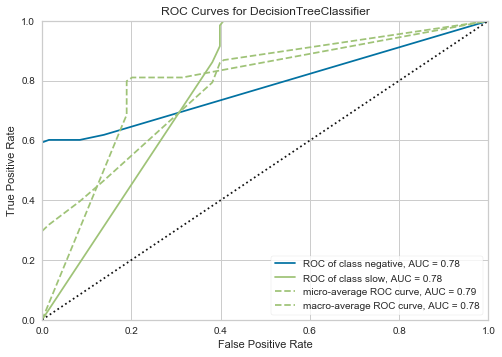

AttributeError: 'DecisionTreeClassifier' object has no attribute 'binary'

In [24]:
#Decision Tree Classifier

from sklearn.metrics import accuracy_score
#Assign model with Decision Tree classifier
acc=[]
depth=[]
for mdepth in range(2, 20, 1):
    
    
    model1 = DecisionTreeClassifier(criterion = "gini",  #gini entropy
            random_state = 150000,max_depth=mdepth, min_samples_leaf=5)
    joblib.dump(model1,"model1")
    model1.fit(x_train, y_train)
    
    #predicting the traget variable using testing variables
    y_pred1 = model1.predict(x_test)
    #Results
    #print("Decision Tree Results")
    #print("Decision Tree Accuracy: ",accuracy_score(y_test, y_pred1)*100,"%")
    acc.append(accuracy_score(y_test, y_pred1))
    depth.append(mdepth)

max_acc_index = acc.index(max(acc))  
#print (max_acc_index)
print ('Optimum Depth is = ', depth[max_acc_index])
acc_max = acc[max_acc_index]
print("Decision Tree Results")
print('Decision Tree Training ACC=', acc_max*100,'%')
optimum_depth = depth[max_acc_index]

#Using optimum depth value to train the model 
model_dt = DecisionTreeClassifier(max_depth = optimum_depth) 
model_dt.fit(x_train, y_train)

#Test the model 
y_pred1 = model_dt.predict(x_test)
optimum_acc= accuracy_score(y_test, y_pred1)
print('Decision Tree Testing ACC =' ,optimum_acc*100,'%')
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred1))
print(plot_ROC_curve(model_dt,x_train, x_test, y_train, y_test))

### Random Forest

5
Optimum Depth is =  7
Random Forest Training ACC= 81.04838709677419 %
Random Forest Testing ACC = 78.62903225806451 %
 Classifiction Report 


              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71       118
         1.0       0.71      1.00      0.83       130

    accuracy                           0.79       248
   macro avg       0.86      0.78      0.77       248
weighted avg       0.85      0.79      0.77       248

Confusion Matrix: 
[[ 65  53]
 [  0 130]]


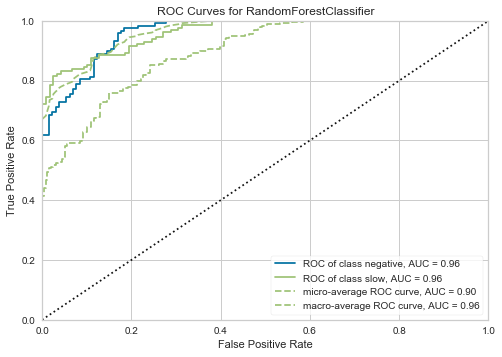

AttributeError: 'RandomForestClassifier' object has no attribute 'binary'

In [25]:
acc=[]
depth=[]
for mdepth in range(2, 30, 1):
    model1 = RandomForestClassifier(n_estimators=150)
    model1.fit(x_train, y_train)
    y_pred1 = model1.predict(x_test)
    acc.append(accuracy_score(y_test, y_pred1))
    depth.append(mdepth)

max_acc_index = acc.index(max(acc))  
print (max_acc_index)
print ('Optimum Depth is = ', depth[max_acc_index])
acc_max =   acc[max_acc_index]
print('Random Forest Training ACC=', acc_max*100,'%')
optimum_depth = depth[max_acc_index]

#Using optimum depth value to train the model 
model_rf = RandomForestClassifier(max_depth = optimum_depth) 
model_rf.fit(x_train, y_train)

#Test the model 
y_pred1 = model_rf.predict(x_test)
optimum_acc= accuracy_score(y_test, y_pred1)
print('Random Forest Testing ACC =' ,optimum_acc*100,'%')
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred1,))
print(plot_ROC_curve(model_rf,x_train, x_test, y_train, y_test))

### SVM (Linear)

In [26]:
from sklearn.svm import SVC
SVM_LK = SVC(C=1.0, kernel='linear',gamma='scale')
LK = SVM_LK.fit(x_train, y_train)
y_pred_train=LK.predict(x_train)
y_pred=LK.predict(x_test)
train_Acc=accuracy_score(y_pred_train,y_train)*100
test_Acc=accuracy_score(y_pred,y_test)*100
print("SvmLinear train Accuracy is : "+str(train_Acc))
print("SvmLinear test Accuracy is : "+str(test_Acc))
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred)
print(classification_report)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score is :" + str(auc_score))

SvmLinear train Accuracy is : 71.50395778364116
SvmLinear test Accuracy is : 78.62903225806451
 Classifiction Report 


              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       118
         1.0       0.80      0.78      0.79       130

    accuracy                           0.79       248
   macro avg       0.79      0.79      0.79       248
weighted avg       0.79      0.79      0.79       248

AUC Score is :0.7863754889178617


### Adaboost

Adaboost Train Acc is : 0.8482849604221636
Adaboost Acc is : 0.7217741935483871
 Classifiction Report 


              precision    recall  f1-score   support

         0.0       1.00      0.55      0.71       118
         1.0       0.71      1.00      0.83       130

    accuracy                           0.79       248
   macro avg       0.86      0.78      0.77       248
weighted avg       0.85      0.79      0.77       248



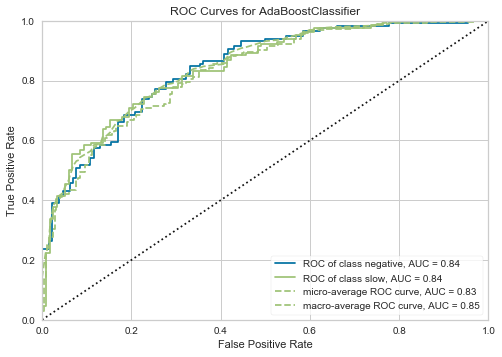

AttributeError: 'AdaBoostClassifier' object has no attribute 'binary'

In [27]:
from sklearn.ensemble import AdaBoostClassifier
Adaboost = AdaBoostClassifier(random_state = 100)
Adaboost = Adaboost.fit(x_train, y_train)
y_pred= Adaboost.predict(x_test)
y_predLG= Adaboost.predict(x_train)
train_Acc=accuracy_score(y_train,y_predLG)
test_Acc=accuracy_score(y_test,y_pred)
print("Adaboost Train Acc is : "+str(train_Acc))
print("Adaboost Acc is : "+str(test_Acc))
print(' Classifiction Report ')
print('\n')
classification_report = metrics.classification_report(y_test, y_pred1)
print(classification_report)
print(plot_ROC_curve(Adaboost,x_train, x_test, y_train, y_test))

## Waveforms


### Plot of Frequency Bands


In [28]:
def plot_freq_band (data_in):
    fs = 512                                # Sampling rate (512 Hz)
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data_in))
    
    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data_in), 1.0/fs)
    #print(fft_freq)
    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}
                # '45 to 100 Hz':(45,100),
                 #'101 to 200 Hz':(101,200)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")

In [29]:
data =  pd.read_csv(r'D:\6th sem\EDAI\2_class_dataset\HPID34\Test\Test_Subject\Shreyas-span-1.csv')
data_A = data.iloc[201:2000,3]

### Waveform of Given Signal

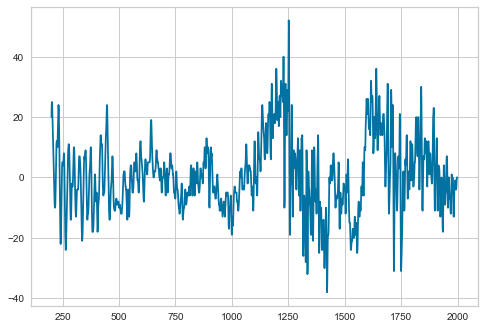

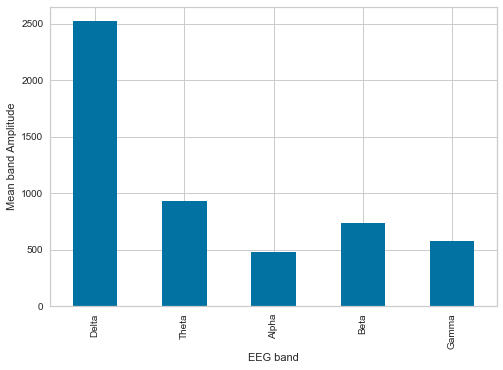

In [30]:
plt.clf()
plt.plot(data_A,'b')
plot_freq_band (data_A)

### Waveform after Notch Filter

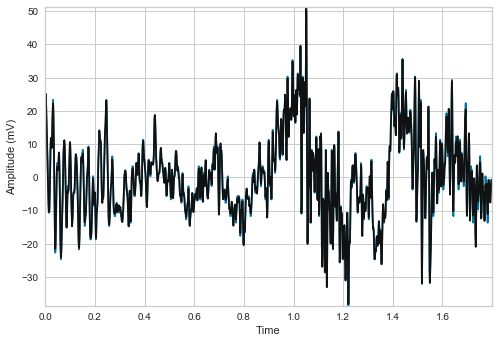

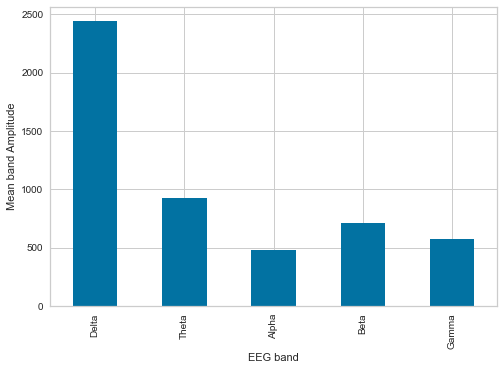

In [31]:
notch_out = notch_filter(data_A, samplerate=1000, plot=True)
#plt.clf()
plot_freq_band (notch_out)
#plt.clf()

### Waveform after Band-pass Filter

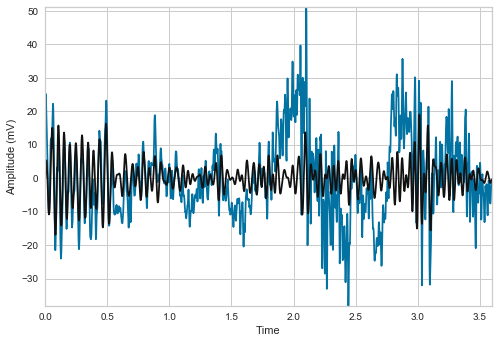

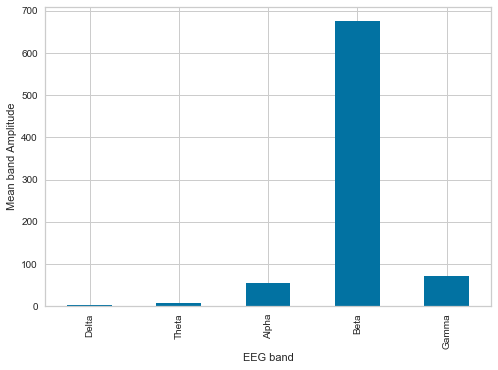

In [32]:
bp_out =  bp_filter(notch_out, low_f=12, high_f=30, samplerate=500, plot=True)
#plt.clf()
plot_freq_band (bp_out)

### Power Spectral Density

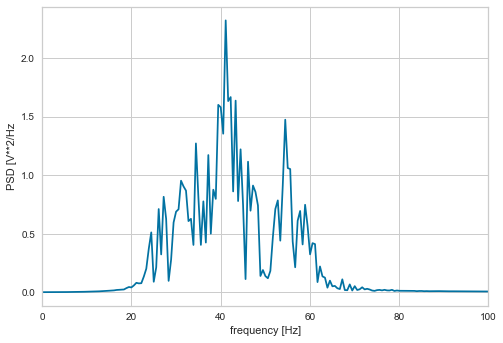

In [33]:
#Power spectral density
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
x= bp_out
dt = 0.001
#X = fft(x)
X=fft(x)/len(x)
freq = fftfreq(x.size, d=dt)

# Only keep positive frequencies.
keep = freq>=0
#X = X[keep]
X=X[keep]*2
freq = freq[keep]

ax1 = plt.subplot(111)
ax1.plot(freq, np.absolute(X))#/3000.)
ax1.set_xlim(0,100)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz')
plt.show()

### 3-D Spectrogram

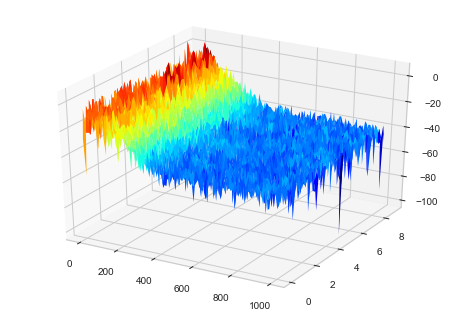

In [34]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal # spectrogram function
from matplotlib import cm # colour map
from mpl_toolkits.mplot3d import Axes3D

mysignal =data.iloc[:,1] # CHANGE THE SIGNAL AND SEE PLOT

# basic config
sample_rate = 2000 #11240.  # 
sig_len_secs = 10
frequency = 2000.

# generate thetimepoint
timestamps_secs = np.arange(sample_rate*sig_len_secs) / sample_rate


# extract the spectrum
freq_bins, timestamps, spec = signal.spectrogram(mysignal, sample_rate)

# 3d plot

fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.subplot(1,1,1,projection="3d"); 
ax.plot_surface(freq_bins[:, None], timestamps[None, :], 10.0*np.log10(spec), cmap=cm.jet)

### Window Slicing

(1899,)


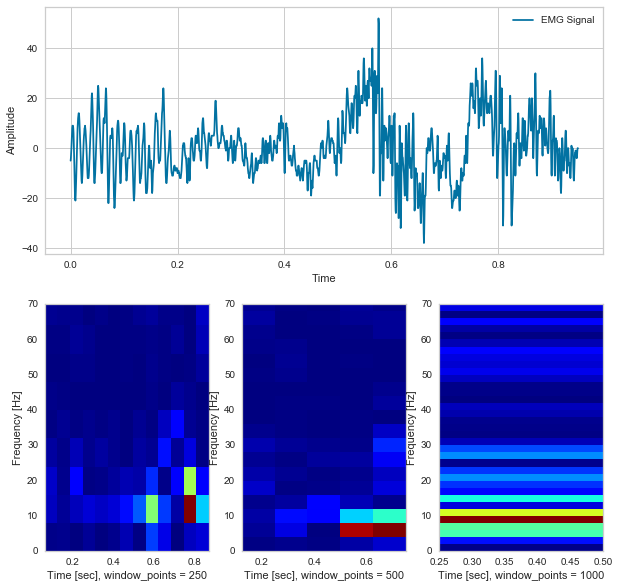

In [35]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-eeg-signal
#Windowing of signal for analysis and discussion of no of datapoints 
# We clim 500 to be the ideal number of data points 
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)
# nperseg = len(Oz[0])-1
#nperseg=50
#f50, t50, Sxx_50 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg-1,window=signal.get_window('hann',nperseg))
#nperseg=150
#f150, t150, Sxx_150 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg-1,window=signal.get_window('hann',nperseg))
#nperseg=350
#f350, t350, Sxx_350 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg-1,window=signal.get_window('hann',nperseg))

nperseg=250
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=1000
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
#50% OVERLAP FOR ALL 3 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'jet')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 250')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'jet')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 500')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'jet')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], window_points = 1000')


plt.show()

(1899,)


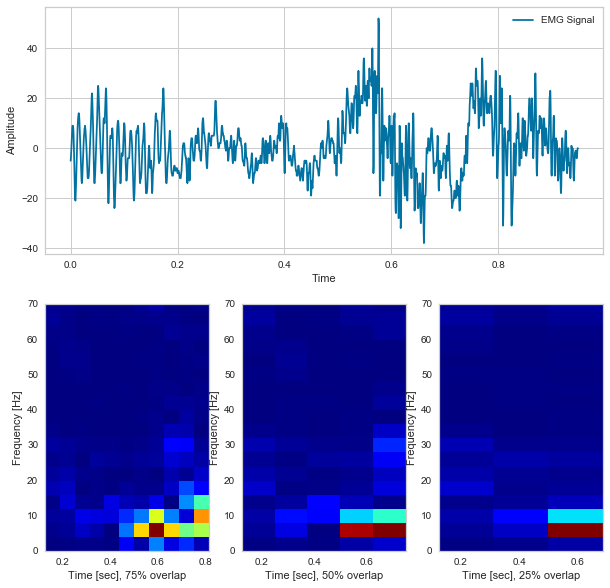

In [36]:
#https://stackoverflow.com/questions/72181057/what-is-the-ideal-parameters-for-spectrogram-of-eeg-signal
#  overlapping of signal analysis and discussion of lenght of overlapping window
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

#y_data = np.genfromtxt('signal_value_spectro.csv', delimiter=',',skip_header=0)

Oz=data.iloc[100:1999,3]#
fs = 2000
t = np.arange(len(Oz))/fs

print(t.shape)

nperseg=500
f250, t250, Sxx_250 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//1.334,window=signal.get_window('hann',nperseg))
nperseg=500
f500, t500, Sxx_500 = signal.spectrogram(Oz, fs, nperseg=nperseg , noverlap=nperseg//2,window=signal.get_window('hann',nperseg))
nperseg=500
f1000, t1000, Sxx_1000 = signal.spectrogram(Oz, fs, nperseg=nperseg ,noverlap=nperseg//4,window=signal.get_window('hann',nperseg))
#ALL 3 have  500 Datapoints 
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(Oz))/fs,Oz)  
plt.legend(['EMG Signal'], loc = 'best')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplot(234)
plt.pcolormesh(t250, f250, Sxx_250, shading='auto',cmap = 'jet')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 75% overlap')
plt.subplot(235)
plt.pcolormesh(t500, f500, Sxx_500, shading='auto',cmap = 'jet')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 50% overlap')
plt.subplot(236)
plt.pcolormesh(t1000, f1000, Sxx_1000, shading='auto',cmap = 'jet')
plt.ylim([0,70])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec], 25% overlap')


plt.show()

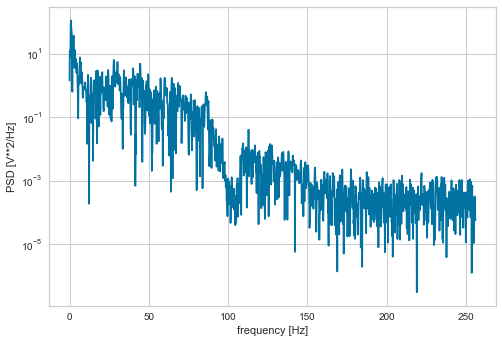

In [37]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
# default Hann window an overlap of 50% 
#Compute and plot the power spectral density.
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()
fs = 512
x   =data.iloc[100:2999,3]
f, Pxx_den = signal.welch(x, fs, nperseg=len(x))
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

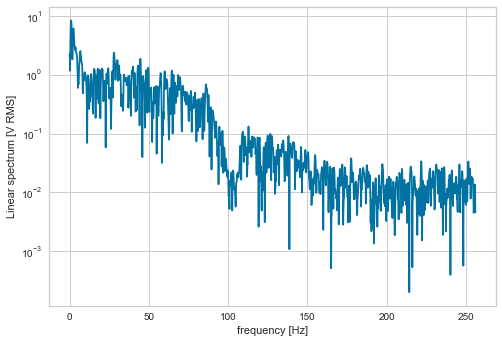

In [38]:
#compute and plot the power spectrum.
f, Pxx_spec = signal.welch(x, fs, 'flattop', len(x), scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

### Box Plot

In [39]:
def boxplot1(data, col):
        print(col)
        #data0 = data[(data.iloc[:,-1] == 0) ] 
        data1 = data[(data.iloc[:,-1] == 1) ] 
        data2 = data[(data.iloc[:,-1] == 0) ] 
       

        data =  [data1[col], data2[col]]#, [data0[col],data4[col], data5[col]]
        #labels = ['Normal (Open Eyes)','Normal (Closed Eyes)','Seizure-free (Hippocampal)','Seizure-free (Epileptic Zone)','Seizure']
        labels = ['CLASS 1','CLASS 2'] #,''CLASS 0',']

        fig = plt.figure(figsize =(4, 3))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(data,labels=labels)
        
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
            plt.setp(bp[element], color = 'blue', linewidth = 2)
        for median in bp['medians']:
            median.set(color = 'red', linewidth = 2.5)
        
        plt.title(col)
        plt.show()

lag1_mean_0


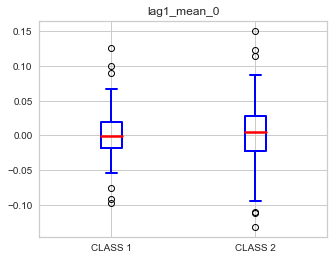

lag1_mean_1


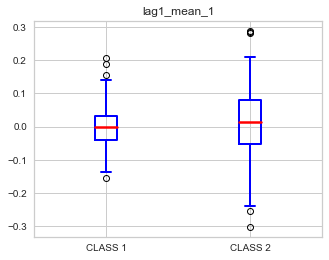

lag1_mean_2


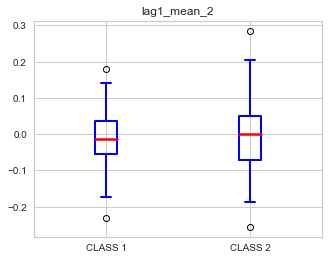

lag1_mean_3


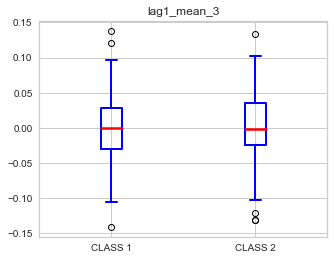

lag1_mean_4


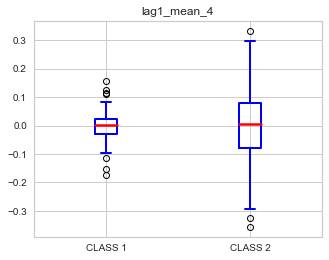

lag1_mean_5


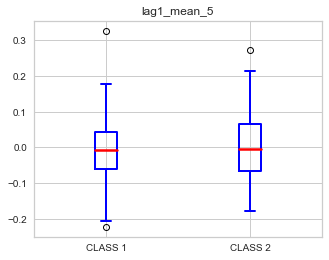

lag1_mean_6


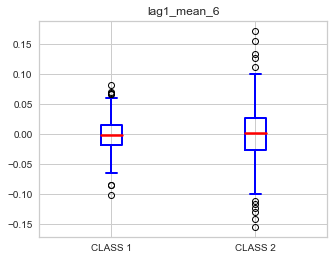

lag1_mean_7


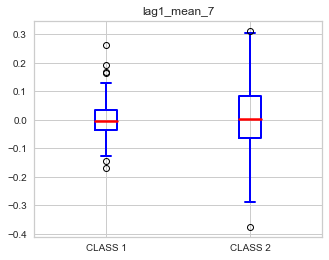

lag1_mean_d_h2h1_0


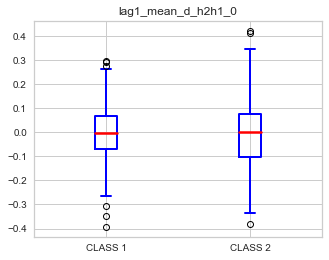

lag1_mean_d_h2h1_1


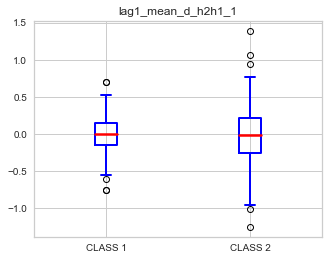

lag1_mean_d_h2h1_2


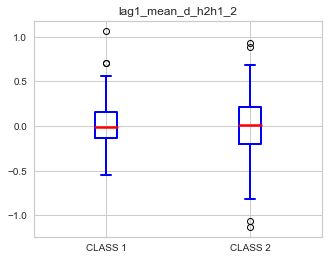

lag1_mean_d_h2h1_3


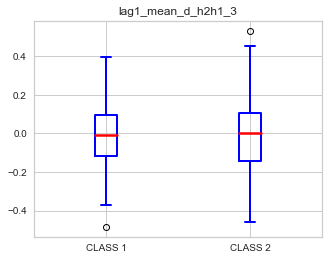

lag1_mean_d_h2h1_4


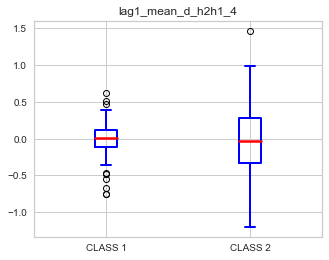

lag1_mean_d_h2h1_5


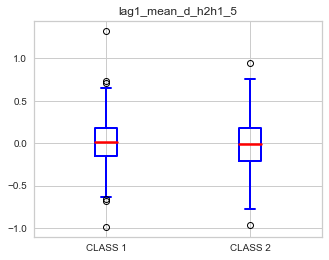

lag1_mean_d_h2h1_6


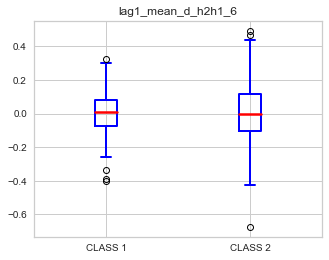

lag1_mean_d_h2h1_7


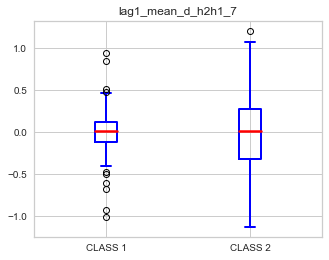

lag1_std_0


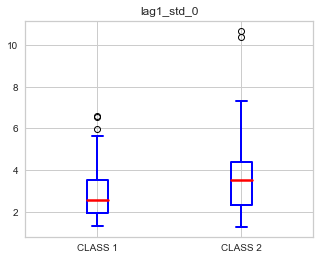

lag1_std_1


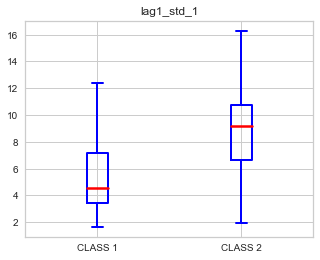

lag1_std_2


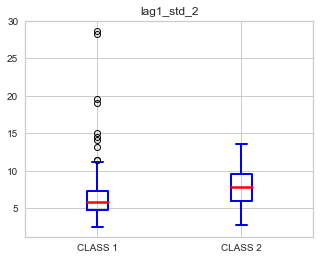

lag1_std_3


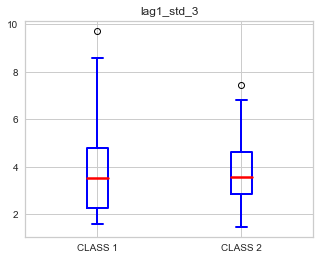

lag1_std_4


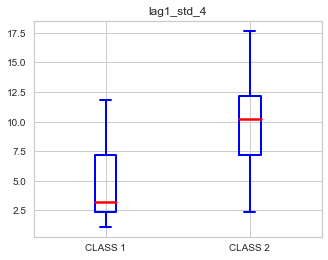

lag1_std_5


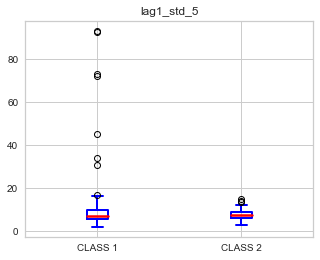

lag1_std_6


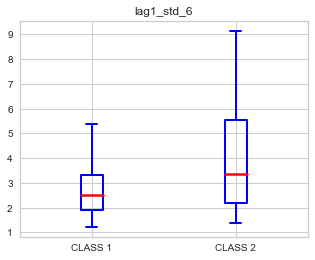

lag1_std_7


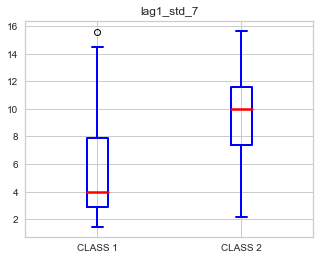

lag1_std_d_h2h1_0


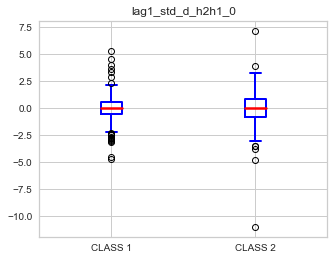

lag1_std_d_h2h1_1


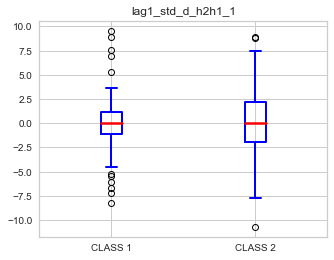

lag1_std_d_h2h1_2


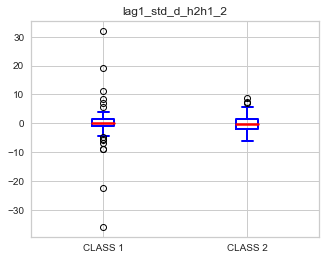

lag1_std_d_h2h1_3


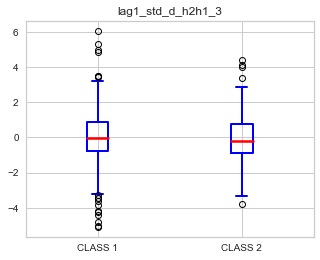

lag1_std_d_h2h1_4


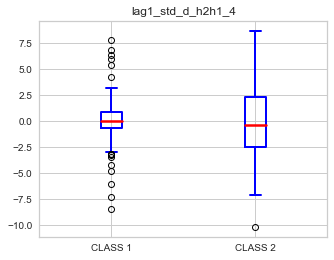

lag1_std_d_h2h1_5


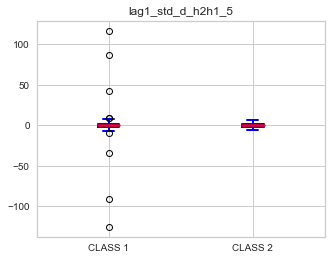

lag1_std_d_h2h1_6


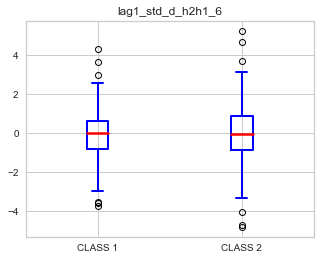

lag1_std_d_h2h1_7


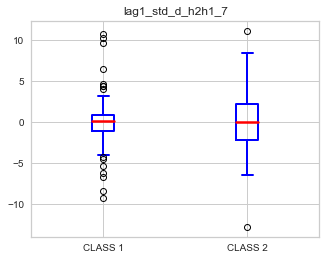

lag1_skew_0


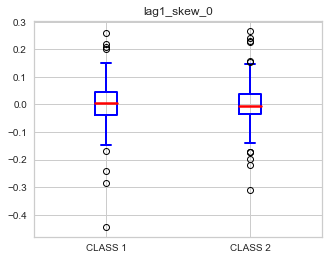

lag1_skew_1


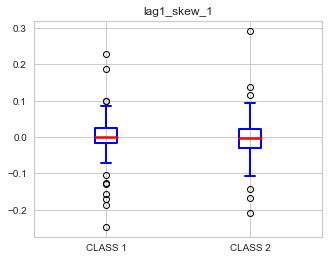

lag1_skew_2


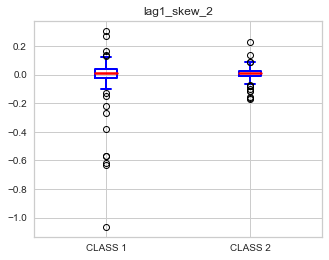

lag1_skew_3


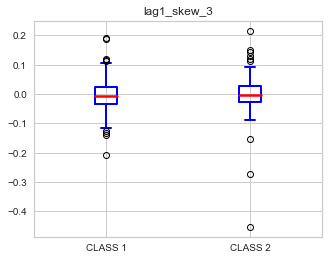

lag1_skew_4


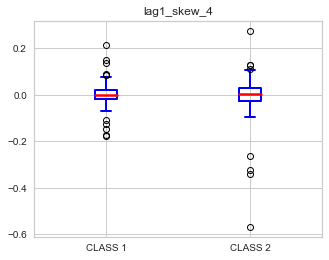

lag1_skew_5


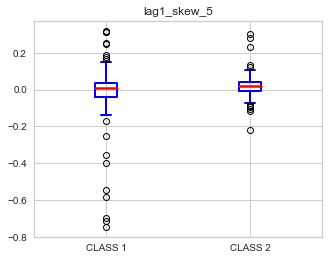

lag1_skew_6


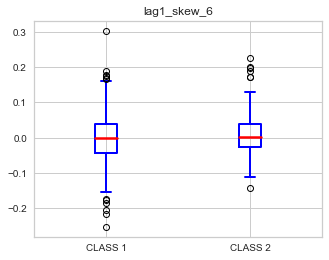

lag1_skew_7


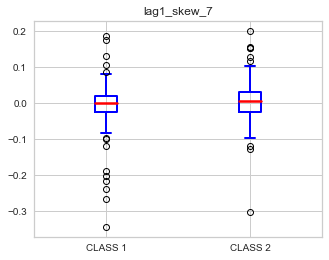

lag1_kurt_0


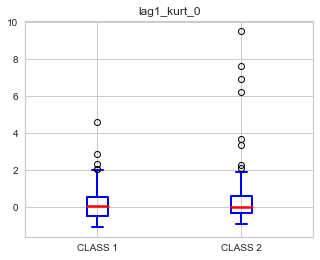

lag1_kurt_1


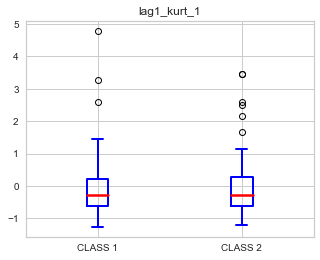

lag1_kurt_2


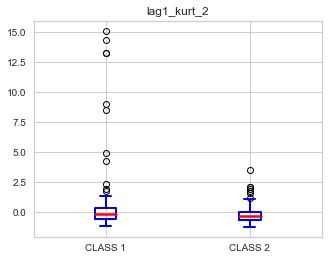

lag1_kurt_3


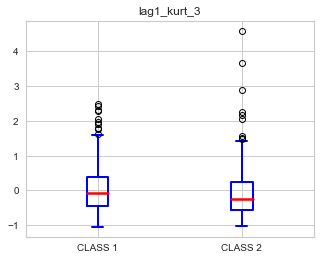

lag1_kurt_4


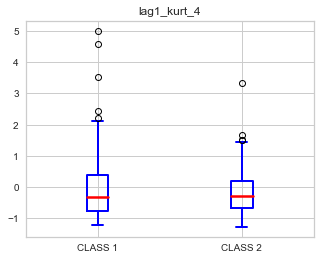

lag1_kurt_5


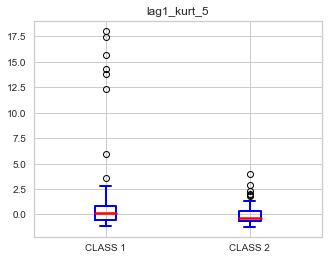

lag1_kurt_6


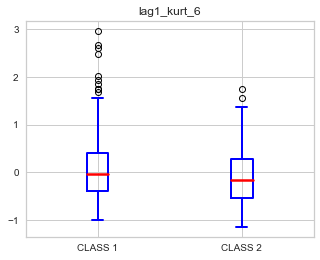

lag1_kurt_7


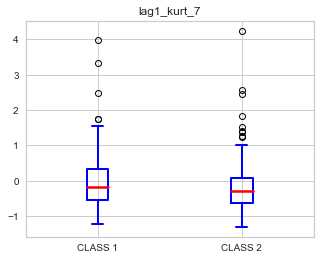

lag1_max_0


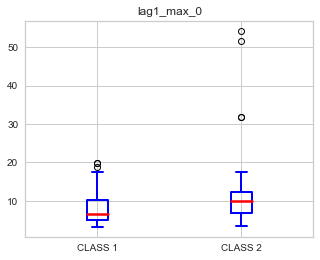

lag1_max_1


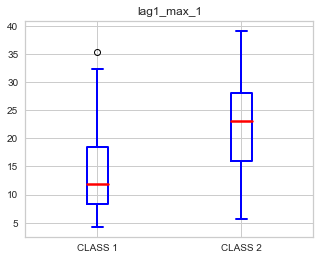

lag1_max_2


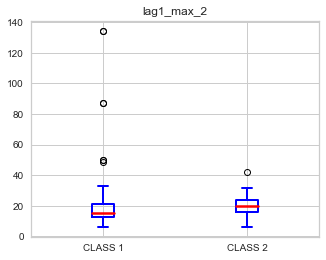

lag1_max_3


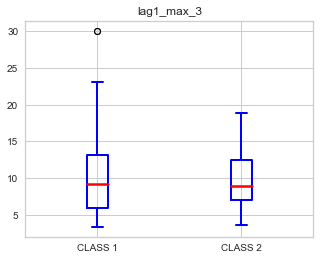

lag1_max_4


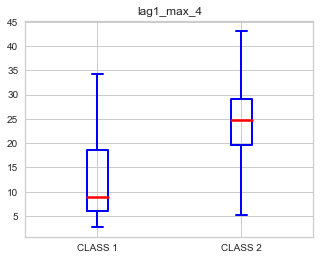

lag1_max_5


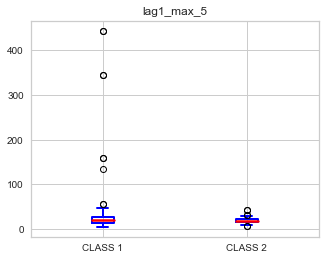

lag1_max_6


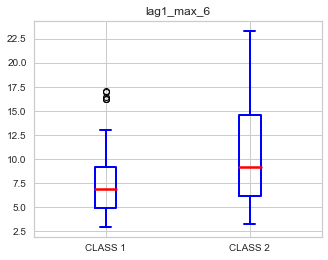

lag1_max_7


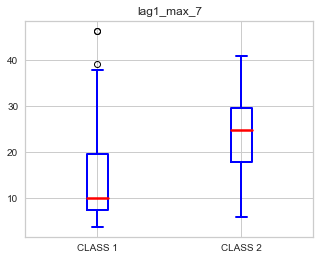

lag1_max_d_h2h1_0


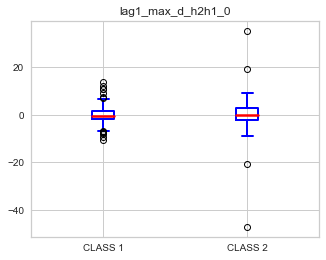

lag1_max_d_h2h1_1


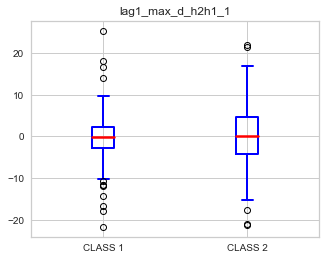

lag1_max_d_h2h1_2


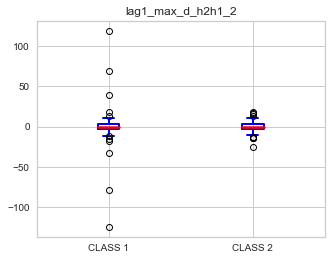

lag1_max_d_h2h1_3


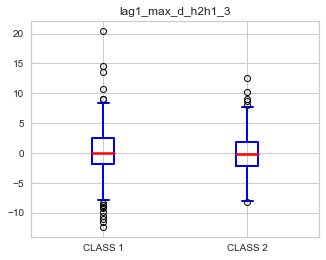

lag1_max_d_h2h1_4


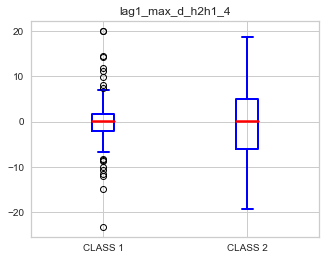

lag1_max_d_h2h1_5


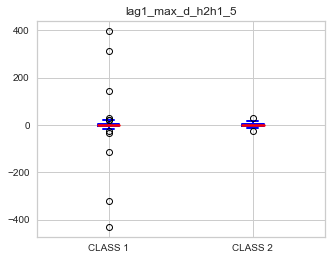

lag1_max_d_h2h1_6


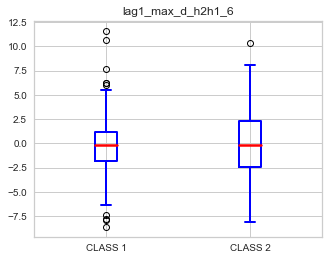

lag1_max_d_h2h1_7


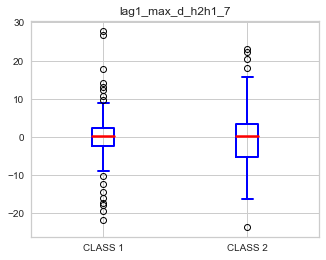

lag1_min_0


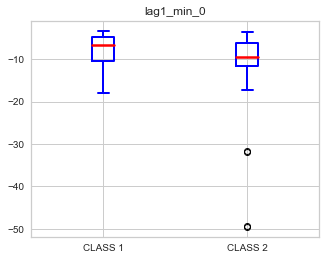

lag1_min_1


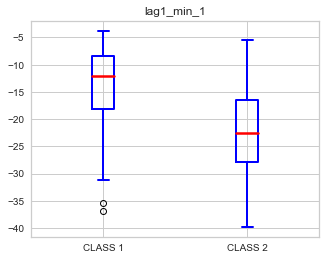

lag1_min_2


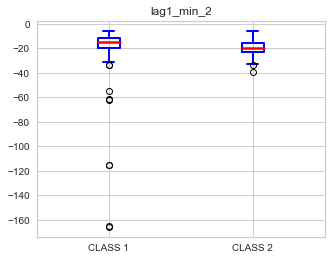

lag1_min_3


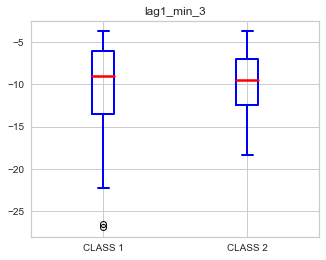

lag1_min_4


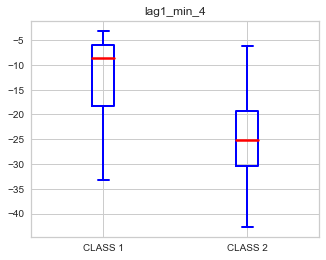

lag1_min_5


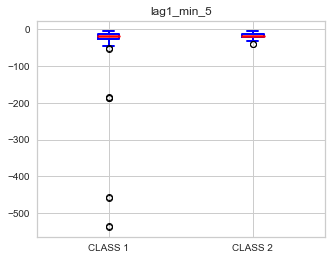

lag1_min_6


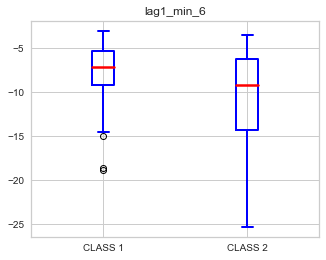

lag1_min_7


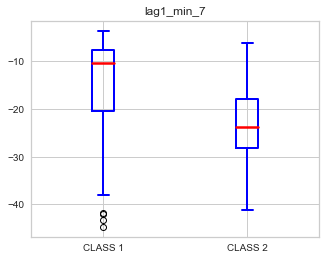

lag1_min_d_h2h1_0


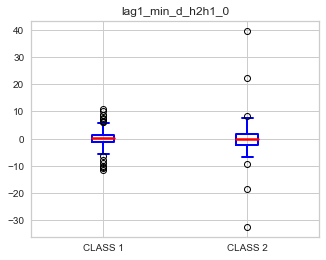

lag1_min_d_h2h1_1


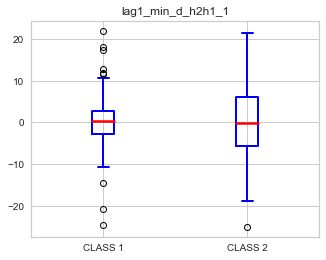

lag1_min_d_h2h1_2


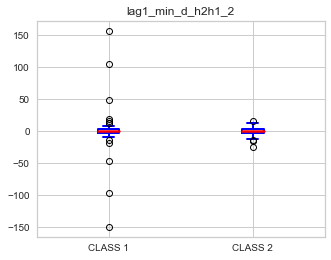

lag1_min_d_h2h1_3


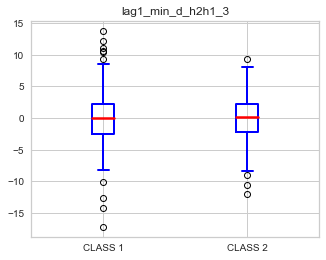

lag1_min_d_h2h1_4


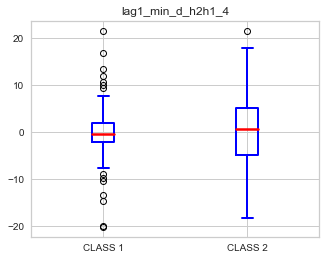

lag1_min_d_h2h1_5


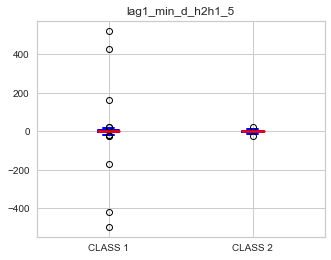

lag1_min_d_h2h1_6


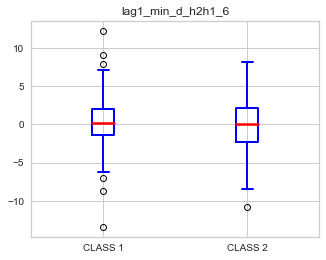

lag1_min_d_h2h1_7


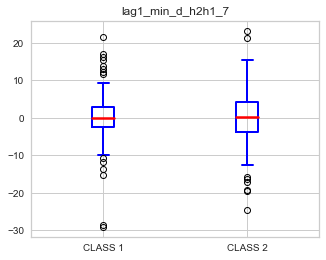

mean_0


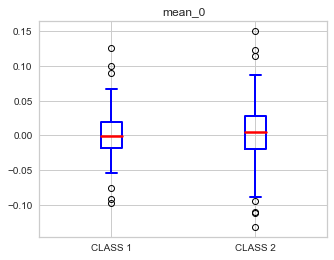

mean_1


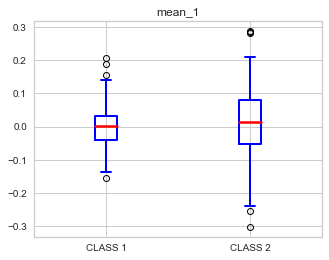

mean_2


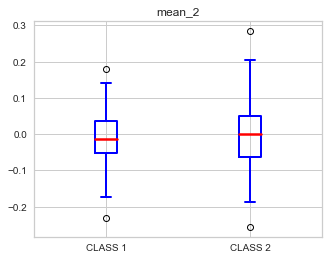

mean_3


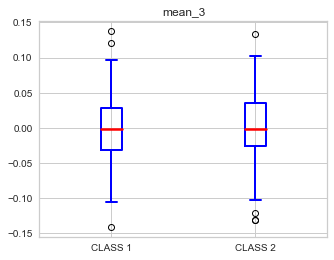

mean_4


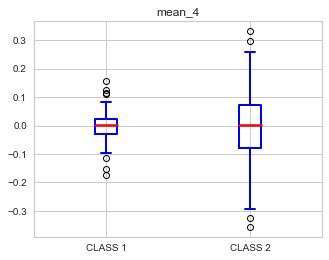

mean_5


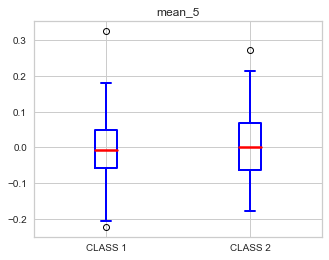

mean_6


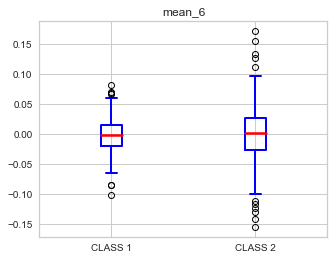

mean_7


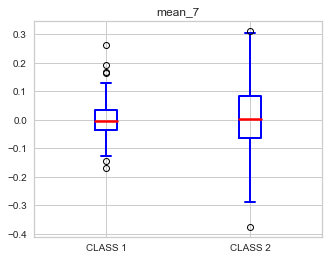

mean_d_h2h1_0


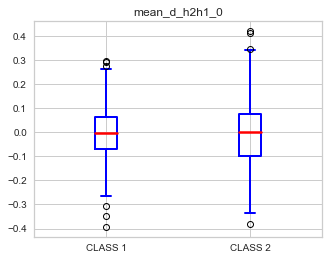

mean_d_h2h1_1


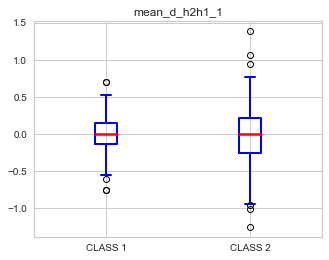

mean_d_h2h1_2


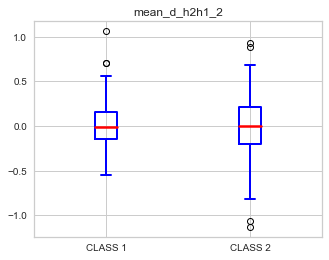

mean_d_h2h1_3


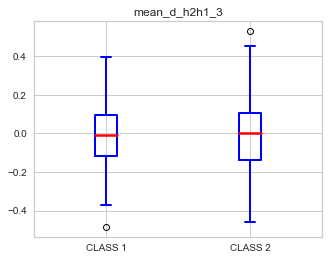

mean_d_h2h1_4


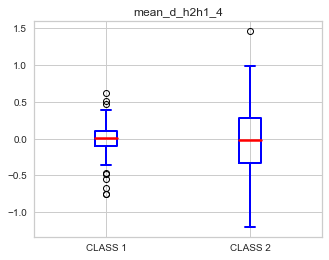

mean_d_h2h1_5


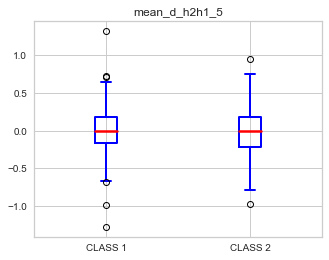

mean_d_h2h1_6


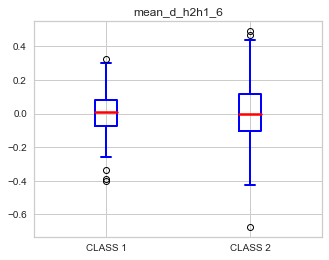

mean_d_h2h1_7


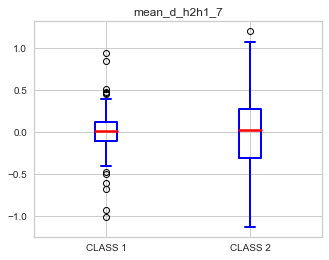

std_0


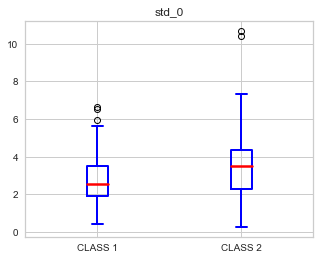

std_1


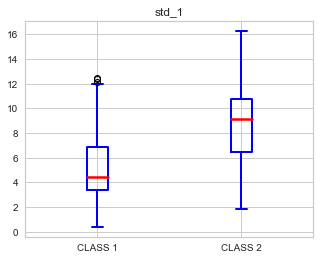

std_2


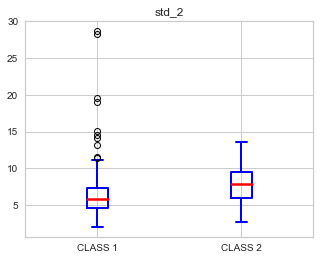

std_3


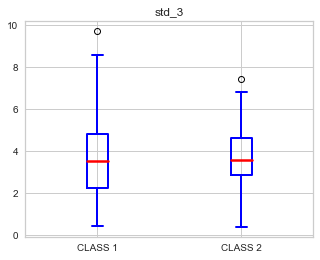

std_4


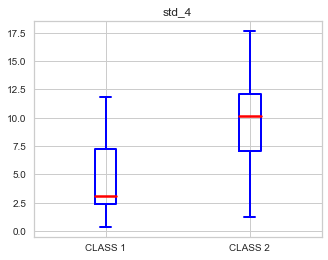

std_5


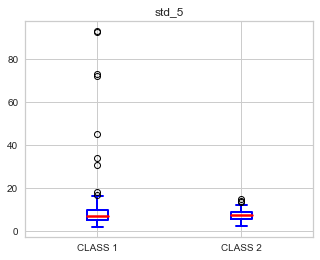

std_6


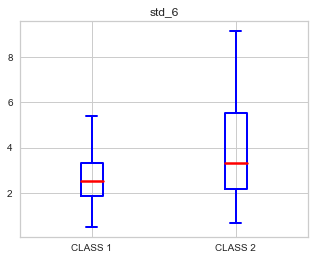

std_7


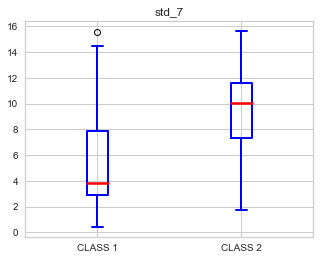

std_d_h2h1_0


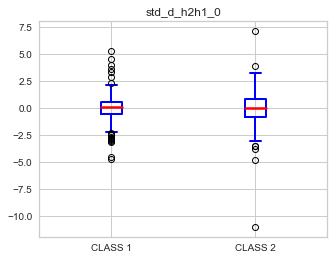

std_d_h2h1_1


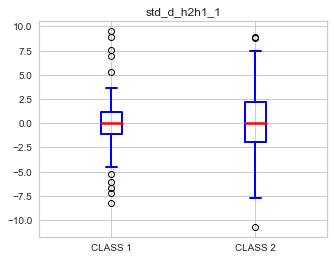

std_d_h2h1_2


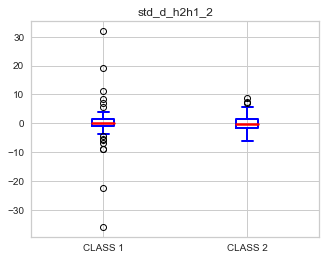

std_d_h2h1_3


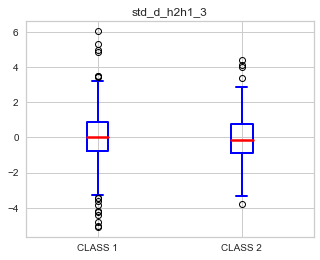

std_d_h2h1_4


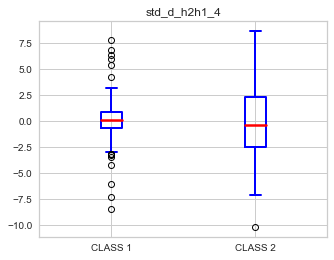

std_d_h2h1_5


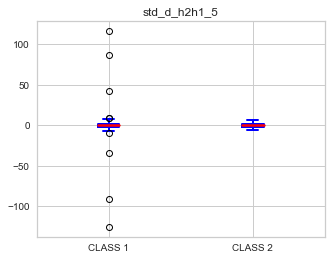

std_d_h2h1_6


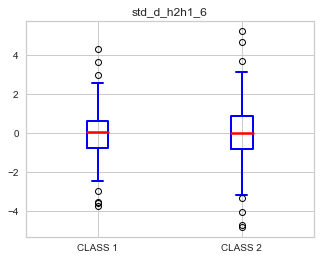

std_d_h2h1_7


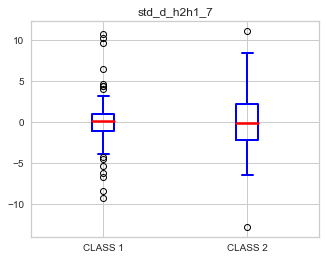

skew_0


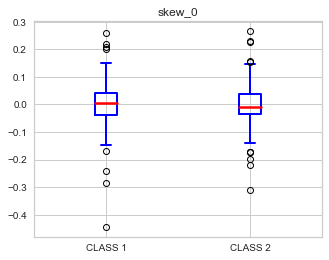

skew_1


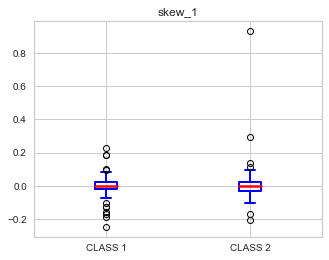

skew_2


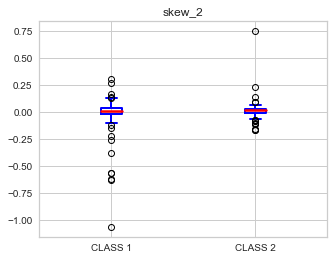

skew_3


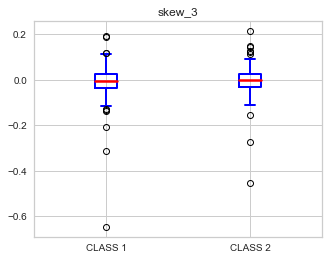

skew_4


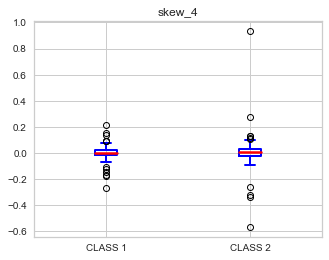

skew_5


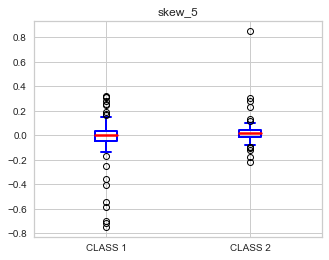

skew_6


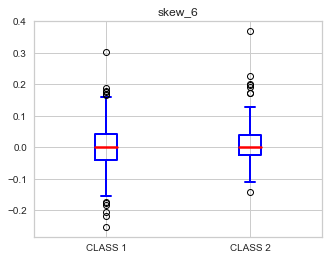

skew_7


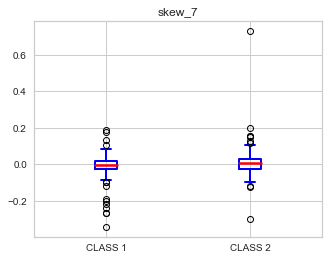

kurt_0


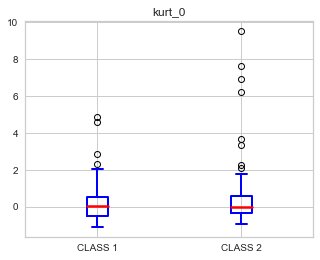

kurt_1


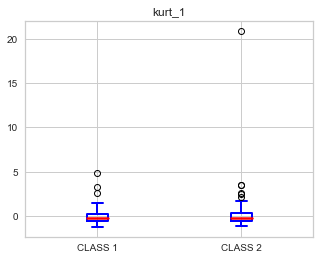

kurt_2


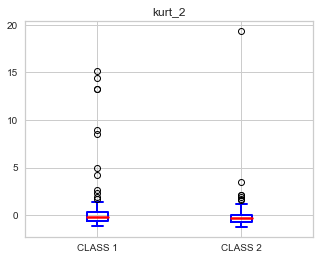

kurt_3


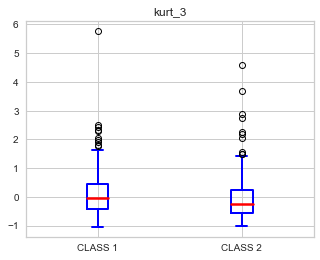

kurt_4


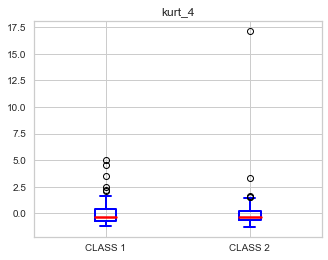

kurt_5


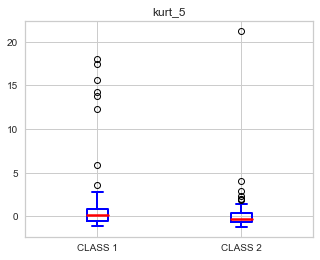

kurt_6


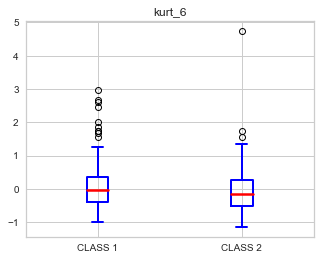

kurt_7


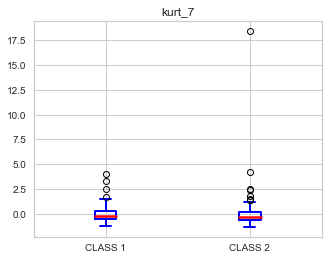

max_0


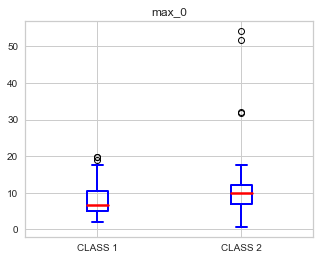

max_1


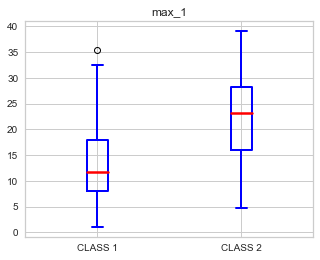

max_2


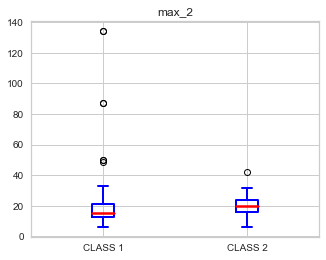

max_3


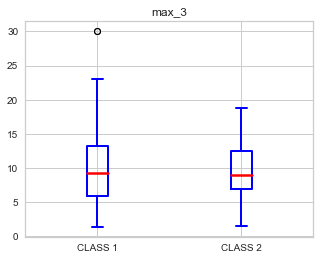

max_4


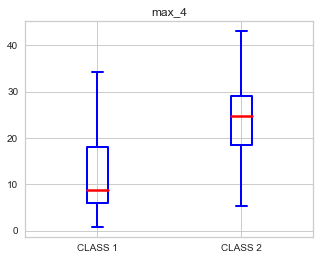

max_5


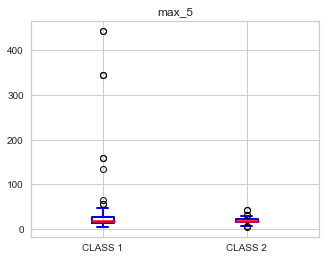

max_6


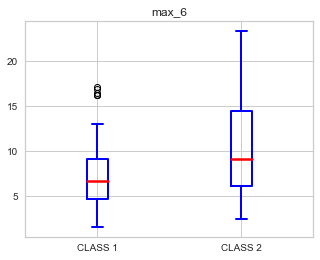

max_7


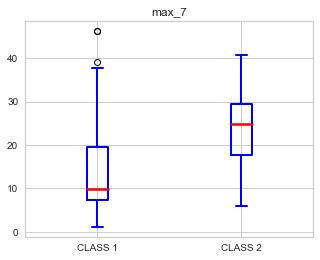

max_d_h2h1_0


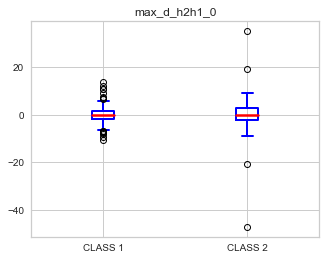

max_d_h2h1_1


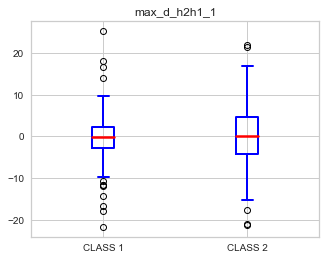

max_d_h2h1_2


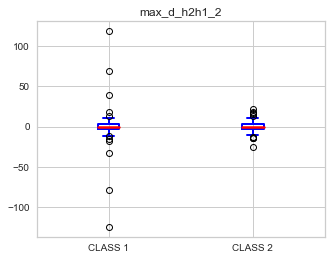

max_d_h2h1_3


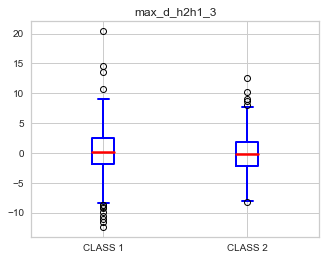

max_d_h2h1_4


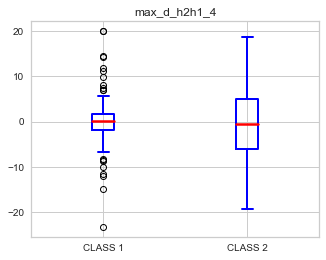

max_d_h2h1_5


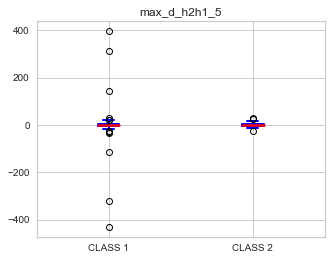

max_d_h2h1_6


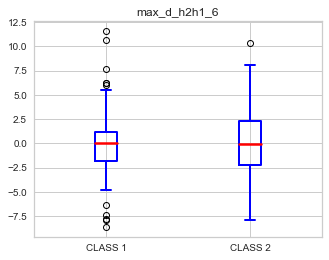

max_d_h2h1_7


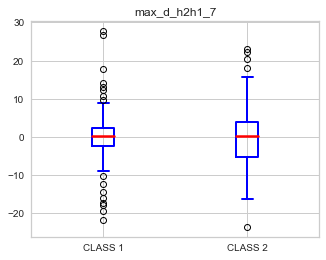

min_0


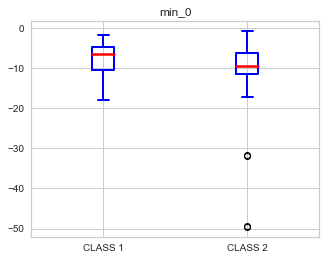

min_1


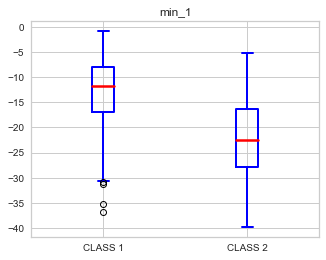

min_2


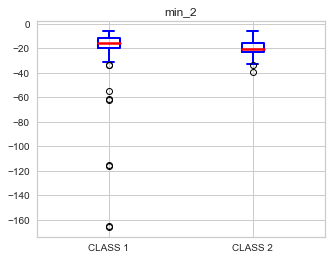

min_3


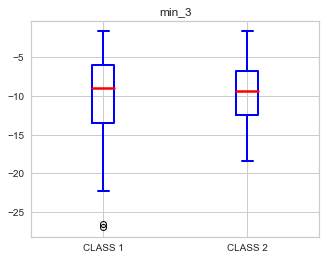

min_4


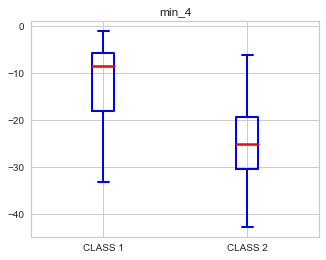

min_5


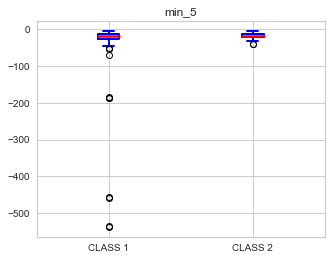

min_6


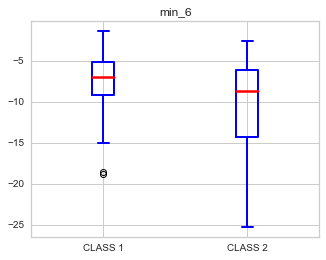

min_7


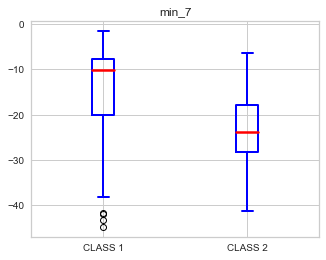

min_d_h2h1_0


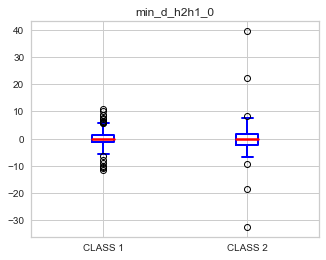

min_d_h2h1_1


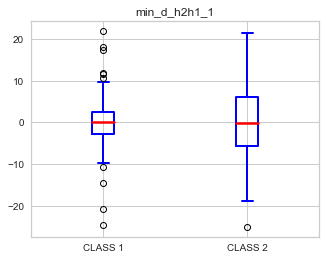

min_d_h2h1_2


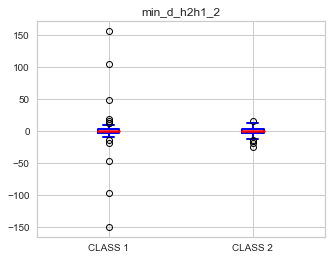

min_d_h2h1_3


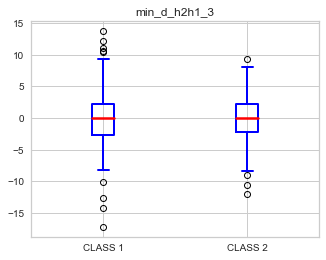

min_d_h2h1_4


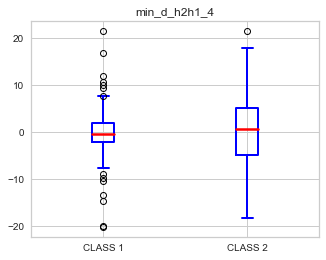

min_d_h2h1_5


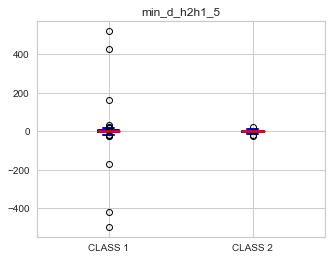

min_d_h2h1_6


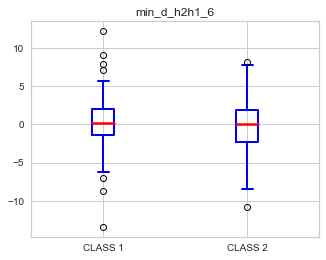

min_d_h2h1_7


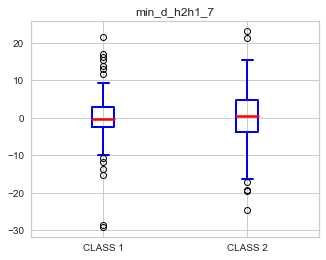

Label


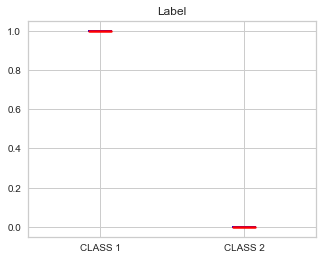

In [40]:
# Python program to illustrate boxplot 
# importing the required module

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

result = Test_set

    # Plotting boxplots
for column in result.columns:
    boxplot1(result, column)